# H3K27ac extra

In [107]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import pandas as pd
import seaborn as sns
from IPython.display import display
from tqdm.auto import tqdm

sns.set_style("whitegrid")
import matplotlib.pyplot as plt
import numpy as np
import os

In [108]:
def bedl(file):
    try:
        tf = pd.read_csv(file, sep='\t', header=None)
        return tf[2] - tf[1]
    except:
        return np.zeros(0)  # Empty file


def lines(file):
    try:
        tf = pd.read_csv(file, sep='\t', header=None)
        return len(tf)
    except:
        return 0  # Empty file


def d(a, b):
    return a / b if b != 0 else 0

def last_col(file):
    try:
        cols = len(pd.read_csv(file, sep='\t', nrows=1, header=None).columns)
        return pd.read_csv(file, sep='\t', header=None, usecols=[cols - 1])[cols - 1]
    except:
        return np.zeros(0)  # Empty file

def sorted_file(file):
    ts = tempfile.mktemp()
    !cat {file} | sort -k1,1 -k2,2n > {ts}
    return ts

# Load hg38 peaks


In [109]:
GSE26320_PATH_HG38 = os.path.expanduser('~/data/2023_GSE26320')
# GSE26320_PATH_HG38 = os.path.expanduser('~/data/2023_GSE26320_no_control')
GSE26320_CELLS = ['GM12878', 'HMEC', 'HSMM', 'K562', 'NHEK', 'NHLF', 'H1', 'Huvec', 'HepG2']
# GSE26320_CELLS = ['GM12878',  'K562', 'H1']
# GSE26320_MODIFICATIONS = ['CTCF', 'H3K27ac', 'H3K27me3', 'H3K36me3', 'H3K4me1', 'H3K4me2', 'H3K4me3', 'H3K9ac', 'H4K20me1']
GSE26320_MODIFICATIONS = ['H3K27ac']
GSE26320_REPS = ['rep1', 'rep2']

! mkdir -p {GSE26320_PATH_HG38}/pics

In [110]:
def load_peaks_fdr(path, suffix, fdrs):
    df_fdr = pd.DataFrame(columns=['file', 'modification', 'cell', 'replicate', 'fdr', 'peaks', 'avlength'],
                          dtype=object)
    for f in tqdm(os.listdir(path)):
        if suffix not in f:
            continue
        fdr = next((fdr for fdr in fdrs if fdr in f), None)
        cell = next((cc for cc in GSE26320_CELLS if cc in f), None)
        mod = next((m for m in GSE26320_MODIFICATIONS if m in f), None)
        rep = next((r for r in GSE26320_REPS if r in f), None)
        if fdr and cell and rep and mod:
            peaks_path = os.path.join(path, f)
            ps, ls = lines(peaks_path), bedl(peaks_path)
            avls = 0 if ps == 0 else sum(ls) / ps
            df_fdr.loc[len(df_fdr)] = (peaks_path, mod, cell, rep, fdr, ps, avls)
    return df_fdr

In [111]:
df_fdr_macs2 = load_peaks_fdr(os.path.join(GSE26320_PATH_HG38, 'macs2'), '.narrowPeak', ['0.05'])
df_fdr_macs2['tool'] = 'MACS2'
print('MACS2', len(df_fdr_macs2))

df_fdr_macs2broad = load_peaks_fdr(os.path.join(GSE26320_PATH_HG38, 'macs2'), '.broadPeak', ['0.1'])
df_fdr_macs2broad['tool'] = 'MACS2 broad'
print('MACS2 broad', len(df_fdr_macs2broad))

df_fdr_sicer = load_peaks_fdr(os.path.join(GSE26320_PATH_HG38, 'sicer'), 'summary-FDR', ['0.01'])
# df_fdr_sicer = load_peaks_fdr(os.path.join(GSE26320_PATH_HG38, 'sicer'), '.scoreisland', ['0.01'])
df_fdr_sicer['tool'] = 'SICER'
print('SICER', len(df_fdr_sicer))

df_fdr_span = load_peaks_fdr(os.path.join(GSE26320_PATH_HG38, 'span'), '.peak', ['0.05'])
df_fdr_span['tool'] = 'SPAN'
print('SPAN', len(df_fdr_span))

TOOLS = ['MACS2', 'MACS2 broad', 'SICER', 'SPAN']
df_fdr_peaks = pd.concat([df_fdr_macs2, df_fdr_macs2broad, df_fdr_sicer, df_fdr_span])
df_fdr_peaks.sample(5)

  0%|          | 0/680 [00:00<?, ?it/s]

MACS2 17


  0%|          | 0/680 [00:00<?, ?it/s]

MACS2 broad 17


  0%|          | 0/251 [00:00<?, ?it/s]

SICER 17


  0%|          | 0/88 [00:00<?, ?it/s]

SPAN 17


,file,modification,cell,replicate,fdr,peaks,avlength,tool
5,/home/jetbrains/data/2023_GSE26320/sicer/GSM64...,H3K27ac,HSMM,rep1,0.01,36868,3683.354996,SICER
0,/home/jetbrains/data/2023_GSE26320/span/GSM646...,H3K27ac,NHLF,rep1,0.05,40791,2032.445539,SPAN
12,/home/jetbrains/data/2023_GSE26320/span/GSM646...,H3K27ac,NHEK,rep1,0.05,48853,1713.995640,SPAN
2,/home/jetbrains/data/2023_GSE26320/macs2/GSM64...,H3K27ac,NHEK,rep1,0.1,44938,1842.899372,MACS2 broad
14,/home/jetbrains/data/2023_GSE26320/macs2/GSM64...,H3K27ac,Huvec,rep2,0.1,26253,1479.835105,MACS2 broad


In [112]:
TOOLS = ['MACS2', 'MACS2 broad', 'SPAN', 'SICER']
palette = plt.cm.get_cmap('tab10')
TOOLS_PALETTE = {t: palette(i) for i, t in enumerate(TOOLS)}

# Update peaks to contain only percentile only

In [113]:
# df_fdr_peaks.drop(['avlength'], axis=1, inplace=True)
df_fdr_peaks['original_file'] = df_fdr_peaks['file']

step = 20
for percentage in [0, 20, 40, 60, 80]:
    percentage_name = f'{percentage}%-{percentage + step}%'
    ! mkdir -p {GSE26320_PATH_HG38}/percentiles/{percentage_name}
    print(percentage_name)
    percentile_files = []
    for file, cell, replicate in tqdm(zip(df_fdr_peaks['file'], df_fdr_peaks['cell'], df_fdr_peaks['replicate'])):
        union_path = f'{GSE26320_PATH_HG38}/union/H3K27ac_{cell}_{replicate}.bed'
        t = pd.read_csv(union_path, sep='\t', header=None, usecols=[0, 1, 2])
        t[3] = t[2] - t[1]
        t.sort_values(by=[3, 0, 1, 2], inplace=True)
    
        pf = f'{GSE26320_PATH_HG38}/percentiles/{percentage_name}_H3K27ac_{cell}_{replicate}.bed'
        # Take % peaks by lengths and compute ratios inside
        t.iloc[int(len(t) * percentage / 100):int(len(t) * (percentage + step) / 100)][[0, 1, 2]].to_csv(
            pf, sep='\t', index=False, header=None
        )
        # Prepare percentage
        file_perc = f'{GSE26320_PATH_HG38}/percentiles/{percentage_name}/{os.path.basename(file)}' 
        print(percentage_name, cell, replicate, file_perc)
        ! bedtools intersect -wa -u -a {sorted_file(file)} -b {sorted_file(pf)} > {file_perc}
        percentile_files.append(file_perc)
    df_fdr_peaks[percentage_name] = percentile_files

df_fdr_peaks.sample(5)

0%-20%


0it [00:00, ?it/s]

0%-20% HepG2 rep2 /home/jetbrains/data/2023_GSE26320/percentiles/0%-20%/GSM646356_HepG2_H3K27ac_rep2_q0.05_peaks.narrowPeak
0%-20% GM12878 rep2 /home/jetbrains/data/2023_GSE26320/percentiles/0%-20%/GSM646317_GM12878_H3K27ac_rep2_q0.05_peaks.narrowPeak
0%-20% H1 rep1 /home/jetbrains/data/2023_GSE26320/percentiles/0%-20%/GSM646336_H1_H3K27ac_rep1_q0.05_peaks.narrowPeak
0%-20% NHLF rep2 /home/jetbrains/data/2023_GSE26320/percentiles/0%-20%/GSM646477_NHLF_H3K27ac_rep2_q0.05_peaks.narrowPeak
0%-20% HepG2 rep1 /home/jetbrains/data/2023_GSE26320/percentiles/0%-20%/GSM646355_HepG2_H3K27ac_rep1_q0.05_peaks.narrowPeak
0%-20% K562 rep1 /home/jetbrains/data/2023_GSE26320/percentiles/0%-20%/GSM646434_K562_H3K27ac_rep1_q0.05_peaks.narrowPeak
0%-20% HSMM rep2 /home/jetbrains/data/2023_GSE26320/percentiles/0%-20%/GSM646395_HSMM_H3K27ac_rep2_q0.05_peaks.narrowPeak
0%-20% Huvec rep1 /home/jetbrains/data/2023_GSE26320/percentiles/0%-20%/GSM646414_Huvec_H3K27ac_rep1_q0.05_peaks.narrowPeak
0%-20% HSMM rep1

0it [00:00, ?it/s]

20%-40% HepG2 rep2 /home/jetbrains/data/2023_GSE26320/percentiles/20%-40%/GSM646356_HepG2_H3K27ac_rep2_q0.05_peaks.narrowPeak
20%-40% GM12878 rep2 /home/jetbrains/data/2023_GSE26320/percentiles/20%-40%/GSM646317_GM12878_H3K27ac_rep2_q0.05_peaks.narrowPeak
20%-40% H1 rep1 /home/jetbrains/data/2023_GSE26320/percentiles/20%-40%/GSM646336_H1_H3K27ac_rep1_q0.05_peaks.narrowPeak
20%-40% NHLF rep2 /home/jetbrains/data/2023_GSE26320/percentiles/20%-40%/GSM646477_NHLF_H3K27ac_rep2_q0.05_peaks.narrowPeak
20%-40% HepG2 rep1 /home/jetbrains/data/2023_GSE26320/percentiles/20%-40%/GSM646355_HepG2_H3K27ac_rep1_q0.05_peaks.narrowPeak
20%-40% K562 rep1 /home/jetbrains/data/2023_GSE26320/percentiles/20%-40%/GSM646434_K562_H3K27ac_rep1_q0.05_peaks.narrowPeak
20%-40% HSMM rep2 /home/jetbrains/data/2023_GSE26320/percentiles/20%-40%/GSM646395_HSMM_H3K27ac_rep2_q0.05_peaks.narrowPeak
20%-40% Huvec rep1 /home/jetbrains/data/2023_GSE26320/percentiles/20%-40%/GSM646414_Huvec_H3K27ac_rep1_q0.05_peaks.narrowPeak


0it [00:00, ?it/s]

40%-60% HepG2 rep2 /home/jetbrains/data/2023_GSE26320/percentiles/40%-60%/GSM646356_HepG2_H3K27ac_rep2_q0.05_peaks.narrowPeak
40%-60% GM12878 rep2 /home/jetbrains/data/2023_GSE26320/percentiles/40%-60%/GSM646317_GM12878_H3K27ac_rep2_q0.05_peaks.narrowPeak
40%-60% H1 rep1 /home/jetbrains/data/2023_GSE26320/percentiles/40%-60%/GSM646336_H1_H3K27ac_rep1_q0.05_peaks.narrowPeak
40%-60% NHLF rep2 /home/jetbrains/data/2023_GSE26320/percentiles/40%-60%/GSM646477_NHLF_H3K27ac_rep2_q0.05_peaks.narrowPeak
40%-60% HepG2 rep1 /home/jetbrains/data/2023_GSE26320/percentiles/40%-60%/GSM646355_HepG2_H3K27ac_rep1_q0.05_peaks.narrowPeak
40%-60% K562 rep1 /home/jetbrains/data/2023_GSE26320/percentiles/40%-60%/GSM646434_K562_H3K27ac_rep1_q0.05_peaks.narrowPeak
40%-60% HSMM rep2 /home/jetbrains/data/2023_GSE26320/percentiles/40%-60%/GSM646395_HSMM_H3K27ac_rep2_q0.05_peaks.narrowPeak
40%-60% Huvec rep1 /home/jetbrains/data/2023_GSE26320/percentiles/40%-60%/GSM646414_Huvec_H3K27ac_rep1_q0.05_peaks.narrowPeak


0it [00:00, ?it/s]

60%-80% HepG2 rep2 /home/jetbrains/data/2023_GSE26320/percentiles/60%-80%/GSM646356_HepG2_H3K27ac_rep2_q0.05_peaks.narrowPeak
60%-80% GM12878 rep2 /home/jetbrains/data/2023_GSE26320/percentiles/60%-80%/GSM646317_GM12878_H3K27ac_rep2_q0.05_peaks.narrowPeak
60%-80% H1 rep1 /home/jetbrains/data/2023_GSE26320/percentiles/60%-80%/GSM646336_H1_H3K27ac_rep1_q0.05_peaks.narrowPeak
60%-80% NHLF rep2 /home/jetbrains/data/2023_GSE26320/percentiles/60%-80%/GSM646477_NHLF_H3K27ac_rep2_q0.05_peaks.narrowPeak
60%-80% HepG2 rep1 /home/jetbrains/data/2023_GSE26320/percentiles/60%-80%/GSM646355_HepG2_H3K27ac_rep1_q0.05_peaks.narrowPeak
60%-80% K562 rep1 /home/jetbrains/data/2023_GSE26320/percentiles/60%-80%/GSM646434_K562_H3K27ac_rep1_q0.05_peaks.narrowPeak
60%-80% HSMM rep2 /home/jetbrains/data/2023_GSE26320/percentiles/60%-80%/GSM646395_HSMM_H3K27ac_rep2_q0.05_peaks.narrowPeak
60%-80% Huvec rep1 /home/jetbrains/data/2023_GSE26320/percentiles/60%-80%/GSM646414_Huvec_H3K27ac_rep1_q0.05_peaks.narrowPeak


0it [00:00, ?it/s]

80%-100% HepG2 rep2 /home/jetbrains/data/2023_GSE26320/percentiles/80%-100%/GSM646356_HepG2_H3K27ac_rep2_q0.05_peaks.narrowPeak
80%-100% GM12878 rep2 /home/jetbrains/data/2023_GSE26320/percentiles/80%-100%/GSM646317_GM12878_H3K27ac_rep2_q0.05_peaks.narrowPeak
80%-100% H1 rep1 /home/jetbrains/data/2023_GSE26320/percentiles/80%-100%/GSM646336_H1_H3K27ac_rep1_q0.05_peaks.narrowPeak
80%-100% NHLF rep2 /home/jetbrains/data/2023_GSE26320/percentiles/80%-100%/GSM646477_NHLF_H3K27ac_rep2_q0.05_peaks.narrowPeak
80%-100% HepG2 rep1 /home/jetbrains/data/2023_GSE26320/percentiles/80%-100%/GSM646355_HepG2_H3K27ac_rep1_q0.05_peaks.narrowPeak
80%-100% K562 rep1 /home/jetbrains/data/2023_GSE26320/percentiles/80%-100%/GSM646434_K562_H3K27ac_rep1_q0.05_peaks.narrowPeak
80%-100% HSMM rep2 /home/jetbrains/data/2023_GSE26320/percentiles/80%-100%/GSM646395_HSMM_H3K27ac_rep2_q0.05_peaks.narrowPeak
80%-100% Huvec rep1 /home/jetbrains/data/2023_GSE26320/percentiles/80%-100%/GSM646414_Huvec_H3K27ac_rep1_q0.05_p

,file,modification,cell,replicate,fdr,peaks,avlength,tool,original_file,0%-20%,20%-40%,40%-60%,60%-80%,80%-100%
1,/home/jetbrains/data/2023_GSE26320/macs2/GSM64...,H3K27ac,GM12878,rep2,0.05,43917,867.432133,MACS2,/home/jetbrains/data/2023_GSE26320/macs2/GSM64...,/home/jetbrains/data/2023_GSE26320/percentiles...,/home/jetbrains/data/2023_GSE26320/percentiles...,/home/jetbrains/data/2023_GSE26320/percentiles...,/home/jetbrains/data/2023_GSE26320/percentiles...,/home/jetbrains/data/2023_GSE26320/percentiles...
1,/home/jetbrains/data/2023_GSE26320/macs2/GSM64...,H3K27ac,NHEK,rep2,0.1,39687,1621.371079,MACS2 broad,/home/jetbrains/data/2023_GSE26320/macs2/GSM64...,/home/jetbrains/data/2023_GSE26320/percentiles...,/home/jetbrains/data/2023_GSE26320/percentiles...,/home/jetbrains/data/2023_GSE26320/percentiles...,/home/jetbrains/data/2023_GSE26320/percentiles...,/home/jetbrains/data/2023_GSE26320/percentiles...
4,/home/jetbrains/data/2023_GSE26320/sicer/GSM64...,H3K27ac,HMEC,rep2,0.01,35171,3578.528589,SICER,/home/jetbrains/data/2023_GSE26320/sicer/GSM64...,/home/jetbrains/data/2023_GSE26320/percentiles...,/home/jetbrains/data/2023_GSE26320/percentiles...,/home/jetbrains/data/2023_GSE26320/percentiles...,/home/jetbrains/data/2023_GSE26320/percentiles...,/home/jetbrains/data/2023_GSE26320/percentiles...
5,/home/jetbrains/data/2023_GSE26320/macs2/GSM64...,H3K27ac,NHLF,rep2,0.1,41503,1689.789774,MACS2 broad,/home/jetbrains/data/2023_GSE26320/macs2/GSM64...,/home/jetbrains/data/2023_GSE26320/percentiles...,/home/jetbrains/data/2023_GSE26320/percentiles...,/home/jetbrains/data/2023_GSE26320/percentiles...,/home/jetbrains/data/2023_GSE26320/percentiles...,/home/jetbrains/data/2023_GSE26320/percentiles...
12,/home/jetbrains/data/2023_GSE26320/sicer/GSM64...,H3K27ac,NHLF,rep2,0.01,37580,3197.286323,SICER,/home/jetbrains/data/2023_GSE26320/sicer/GSM64...,/home/jetbrains/data/2023_GSE26320/percentiles...,/home/jetbrains/data/2023_GSE26320/percentiles...,/home/jetbrains/data/2023_GSE26320/percentiles...,/home/jetbrains/data/2023_GSE26320/percentiles...,/home/jetbrains/data/2023_GSE26320/percentiles...


# Coverage for the given percentile settings

In [114]:
# Compute coverage on given percentile settings
df_fdr_peaks['file'] = df_fdr_peaks['80%-100%']
# df_fdr_peaks['file'] = df_fdr_peaks['0%-20%']
# df_fdr_peaks['file'] = df_fdr_peaks['40%-60%']

In [115]:
# Fraction of reads in peaks
GSE26320_PATH_HG38_BW = GSE26320_PATH_HG38 + '/bw'


def load_bws(path, m):
    df_bws = pd.DataFrame(columns=['file', 'modification', 'cell', 'replicate'], dtype=object)
    for f in tqdm(os.listdir(path)):
        if '.bw' not in f:
            continue
        cell = next((cc for cc in GSE26320_CELLS if cc in f), None)
        rep = next((r for r in GSE26320_REPS if r in f), None)
        if cell and rep and m in f:
            df_bws.loc[len(df_bws)] = ((os.path.join(path, f)), m, cell, rep)
    return df_bws

In [116]:
bws_df = load_bws(GSE26320_PATH_HG38_BW, 'H3K27ac')
display(bws_df.sample(3))
bws_control_df = load_bws(GSE26320_PATH_HG38_BW, 'Input')
display(bws_control_df.sample(3))

  0%|          | 0/103 [00:00<?, ?it/s]

,file,modification,cell,replicate
7,/home/jetbrains/data/2023_GSE26320/bw/GSM64641...,H3K27ac,Huvec,rep2
5,/home/jetbrains/data/2023_GSE26320/bw/GSM64645...,H3K27ac,NHEK,rep2
14,/home/jetbrains/data/2023_GSE26320/bw/GSM64639...,H3K27ac,HSMM,rep1


  0%|          | 0/103 [00:00<?, ?it/s]

,file,modification,cell,replicate
8,/home/jetbrains/data/2023_GSE26320/bw/GSM64639...,Input,HMEC,rep1
16,/home/jetbrains/data/2023_GSE26320/bw/GSM64635...,Input,H1,rep2
7,/home/jetbrains/data/2023_GSE26320/bw/GSM64633...,Input,GM12878,rep2


In [117]:
CHROM_SIZES = {
    c: s for _, (c, s) in pd.read_csv(os.path.join(GSE26320_PATH_HG38, 'hg38.chrom.sizes'),
                                      sep='\t', names=['chr', 'size']).iterrows() if '_' not in c
}

## Peaks Density

In [12]:
import pyBigWig
import tempfile
from itertools import product

tf = tempfile.mktemp()

coverage_data = []

for c, r in tqdm(product(GSE26320_CELLS, GSE26320_REPS)):
    print(c, r)
    t = bws_df[(bws_df['modification'] == 'H3K27ac') &
               (bws_df['cell'] == c) &
               (bws_df['replicate'] == r)]
    if len(t) == 0:
        continue
    bw_file = t['file'].values[0]
    t = bws_control_df[(bws_control_df['cell'] == c) & (bws_control_df['replicate'] == r)]
    if len(t) == 0:
        continue
    bw_control_file = t['file'].values[0]
    for tool in set(df_fdr_peaks['tool']):
        t = df_fdr_peaks[(df_fdr_peaks['tool'] == tool) &
                         (df_fdr_peaks['modification'] == 'H3K27ac') &
                         (df_fdr_peaks['cell'] == c) &
                         (df_fdr_peaks['replicate'] == r)]
        if len(t) == 0:
            continue
        peaks_file = sorted_file(t['file'].values[0])
        if lines(peaks_file) > 0:
            t = pd.read_csv(peaks_file, sep='\t', header=None)
            positions = [f'{chr}:{start}-{end}' for chr, start, end in zip(t[0], t[1], t[2]) if chr in CHROM_SIZES]
            lengths = [end - start for chr, start, end in zip(t[0], t[1], t[2]) if chr in CHROM_SIZES]
            with pyBigWig.open(bw_file) as bw:
                total_coverage = sum(bw.stats(chr, type='sum', exact=True)[0] for chr in t[0].unique() if chr in CHROM_SIZES)
                peaks_coverage = [bw.stats(chr, start, end, type='sum', exact=True)[0]
                                  for chr, start, end in zip(t[0], t[1], t[2]) if chr in CHROM_SIZES]
            for pos, length, peak_coverage in zip(positions, lengths, peaks_coverage):
                coverage_data.append(('H3K27ac', c, r, tool, pos, length, 'treatment', peak_coverage, total_coverage))
            with pyBigWig.open(bw_control_file) as bwc:
                total_coverage = sum(bwc.stats(chr, type='sum', exact=True)[0] for chr in t[0].unique())
                peaks_coverage = [bwc.stats(chr, start, end, type='sum', exact=True)[0]
                                  for chr, start, end in zip(t[0], t[1], t[2])]
            for pos, length, peak_coverage in zip(positions, lengths, peaks_coverage):
                coverage_data.append(('H3K27ac', c, r, tool, pos, length, 'control', peak_coverage, total_coverage))
        if tool == 'SPAN':
            span_file = peaks_file

    # Processing single tools information
    for tool in TOOLS:
        if tool == 'SPAN':
            continue
        t = df_fdr_peaks[(df_fdr_peaks['tool'] == tool) &
                         (df_fdr_peaks['modification'] == 'H3K27ac') &
                         (df_fdr_peaks['cell'] == c) &
                         (df_fdr_peaks['replicate'] == r)]
        if len(t) == 0:
            continue
        peaks_file = sorted_file(t['file'].values[0])
        for name, args in [
            (f'SPAN - {tool}', f' -a {span_file} -b {peaks_file} '),
            (f'{tool} - SPAN', f' -b {span_file} -a {peaks_file} ')
        ]:
            !bedtools intersect {args} -wa -v > {tf}
            if lines(tf) > 0:
                t = pd.read_csv(tf, sep='\t', header=None)
                positions = [f'{chr}:{start}-{end}' for chr, start, end in zip(t[0], t[1], t[2]) if chr in CHROM_SIZES]
                lengths = [end - start for chr, start, end in zip(t[0], t[1], t[2]) if chr in CHROM_SIZES]
                with pyBigWig.open(bw_file) as bw:
                    total_coverage = sum(bw.stats(chr, type='sum', exact=True)[0] for chr in t[0].unique() if chr in CHROM_SIZES)
                    peaks_coverage = [bw.stats(chr, start, end, type='sum', exact=True)[0]
                                      for chr, start, end in zip(t[0], t[1], t[2]) if chr in CHROM_SIZES]
                for pos, length, peak_coverage in zip(positions, lengths, peaks_coverage):
                    coverage_data.append(('H3K27ac', c, r, name, pos, length, 'treatment', peak_coverage, total_coverage))
                with pyBigWig.open(bw_control_file) as bwc:
                    total_coverage = sum(bwc.stats(chr, type='sum', exact=True)[0] for chr in t[0].unique())
                    peaks_coverage = [bwc.stats(chr, start, end, type='sum', exact=True)[0]
                                      for chr, start, end in zip(t[0], t[1], t[2])]
                for pos, length, peak_coverage in zip(positions, lengths, peaks_coverage):
                    coverage_data.append(('H3K27ac', c, r, name, pos, length, 'control', peak_coverage, total_coverage))

df_coverage = pd.DataFrame(
    coverage_data,
    columns=['modification', 'cell', 'replicate', 'name', 'position', 'length', 'type', 'coverage', 'total_coverage']
)
del coverage_data
df_coverage.sample(5)

0it [00:00, ?it/s]

GM12878 rep1
GM12878 rep2
HMEC rep1
HMEC rep2
HSMM rep1
HSMM rep2
K562 rep1
K562 rep2
NHEK rep1
NHEK rep2
NHLF rep1
NHLF rep2
H1 rep1
H1 rep2
Huvec rep1
Huvec rep2
HepG2 rep1
HepG2 rep2


,modification,cell,replicate,name,position,length,type,coverage,total_coverage
1691560,H3K27ac,HepG2,rep2,MACS2 broad,chr6:170552598-170555317,2719,control,86.606300,8.412824e+07
655217,H3K27ac,HSMM,rep2,MACS2,chr6:16724763-16726250,1487,control,55.413198,5.872188e+07
26423,H3K27ac,GM12878,rep1,SICER,chr9:131251400-131258399,6999,treatment,7348.501297,9.599063e+07
1134778,H3K27ac,NHLF,rep1,SICER,chr15:75637000-75641999,4999,control,216.344904,7.895055e+07
788399,H3K27ac,K562,rep2,MACS2 broad,chr11:16346037-16348584,2547,treatment,913.255134,6.589202e+07


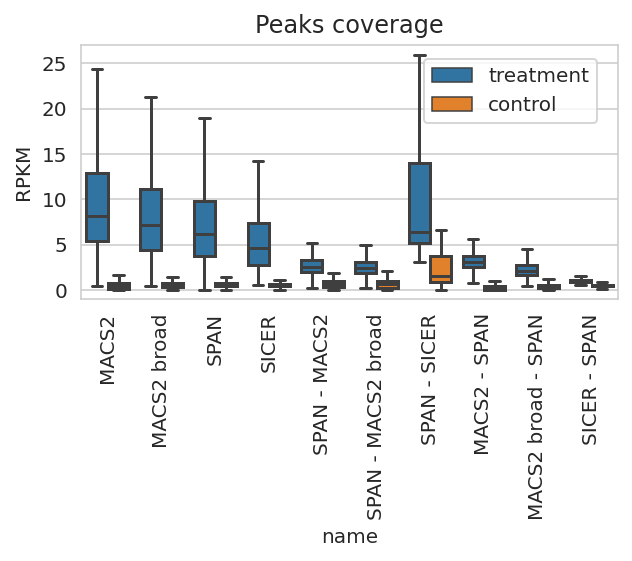

In [13]:
df_coverage['rpm'] = df_coverage['coverage'] / (df_coverage['total_coverage'] / 1e6)
df_coverage['rpkm'] = df_coverage['rpm'] / (df_coverage['length'] / 1e3)

plt.figure(figsize=(4.5, 4))
g_results = sns.boxplot(data=df_coverage, x='name', y='rpkm', hue='type',
                        order=['MACS2', 'MACS2 broad',  'SPAN', 'SICER',
                               'SPAN - MACS2', 'SPAN - MACS2 broad', 'SPAN - SICER',
                               'MACS2 - SPAN', 'MACS2 broad - SPAN', 'SICER - SPAN',
                               ],
                        showfliers=False)
ax = g_results.axes
ax.xaxis.set_tick_params(rotation=90)
ax.set_ylabel('RPKM')
ax.set_ylim(-1, 27)
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(0.62, 0.82))
plt.title('Peaks coverage')
plt.tight_layout()
plt.show()

# Prepare datasets with wiggling and mixing control data into signal track

## Wiggle bed files

In [14]:
WD = os.path.expanduser('~/data/2023_GSE26320_wiggle_80_100')

percentile_file = f'{WD}/80%-100%_H3K27ac_GM12878_rep1.bed'
bed = f'{WD}/GSM646316_GM12878_H3K27ac_rep1.bed'
tf1 = tempfile.mktemp()
tf2 = tempfile.mktemp()
! bedtools intersect -a {sorted_file(bed)} -b {sorted_file(percentile_file)} -wa > {tf1}
! bedtools intersect -a {sorted_file(bed)} -b {sorted_file(percentile_file)} -wa -v > {tf2}
tf1_len, tf2_len = lines(tf1), lines(tf2)
print('Overlapping', tf1_len, 'Non-onverlapping', tf2_len)

Overlapping 2725496 Non-onverlapping 4323562


In [15]:
t = pd.read_csv(tf1, sep='\t', header=None)
t.sample(5)

,0,1,2,3,4,5
274320,chr10,11681765,11681816,SRR094196.17369616,42,-
1359901,chr2,54560411,54560462,SRR094196.20141971,42,-
2458313,chr8,22447793,22447844,SRR094196.4484564,42,-
1574317,chr20,44966459,44966510,SRR094196.26650824,40,+
2512632,chr8,95145183,95145234,SRR094196.13230382,42,+


In [16]:
# Wiggle signal in 80-100% area 
signal = t.sample(int(len(t) * 0.5))
noise = t.sample(int(len(t) * 0.5))
delta = [int(x) for x in np.random.normal(0, 5_000, size=len(noise))]
noise[1] += delta
noise[2] += delta
# Ensure generated reads have proper coordinates
noise.loc[noise[1] < 1, 1] = 1
noise.loc[noise[2] < 1, 2] = 1

In [17]:
t = pd.concat([signal, noise]).reset_index(drop=True)
t.to_csv(tf1, sep='\t', index=False, header=None)

In [18]:
result_file = f'{WD}/GSM646316_GM12878_H3K27ac_rep1_wiggle.bed'
! cat {tf1} > {result_file}
! cat {tf2} >> {result_file}

In [19]:
del t

## Mixing with input

In [20]:
signal = pd.read_csv(bed, sep='\t', header=None)
reads = len(signal)
signal.sample(5)

,0,1,2,3,4,5
823124,chr4,14125274,14125325,SRR094196.25106445,42,-
1557279,chr14,65170915,65170966,SRR094196.18691401,42,-
2306417,chr9,33594511,33594562,SRR094196.24501863,30,-
1389929,chr20,49891283,49891334,SRR094196.24567500,42,+
1053110,chr4,149026584,149026635,SRR094196.24375995,42,+


In [21]:
input = f'{WD}/GSM646332_GM12878_Input_rep1.bed'
noise = pd.read_csv(input, sep='\t', header=None)
noise.sample(5)

,0,1,2,3,4,5
976602,chr4,153155592,153155643,SRR094215.3537525,42,-
5269747,chr2,29837960,29838011,SRR094215.1177755,42,-
1810293,chr8,118367215,118367266,SRR094215.1992228,42,-
2250066,chr10,5149236,5149287,SRR094215.1634140,39,-
85073,chr18,46711818,46711869,SRR094215.2247449,40,+


In [22]:
signal = signal.sample(int(reads * 0.5))
noise = noise.sample(int(reads * 0.5))
signal.to_csv(tf1, sep='\t', index=False, header=None)
noise.to_csv(tf2, sep='\t', index=False, header=None)
result_file = f'{WD}/GSM646316_GM12878_H3K27ac_rep1_mix.bed'
! cat {tf1} > {result_file}
! cat {tf2} >> {result_file}

In [23]:
del signal, noise

# Lengths distribution in noise conditions

Please rerun snakemake smk-chipseq-pipeline for mix and wiggle tracks.

In [24]:
df_fdr_macs2 = load_peaks_fdr(os.path.join(WD, 'macs2'), '.narrowPeak', ['0.05'])
df_fdr_macs2['tool'] = 'MACS2'
print('MACS2', len(df_fdr_macs2))

df_fdr_macs2broad = load_peaks_fdr(os.path.join(WD, 'macs2'), '.broadPeak', ['0.1'])
df_fdr_macs2broad['tool'] = 'MACS2 broad'
print('MACS2 broad', len(df_fdr_macs2broad))

df_fdr_sicer = load_peaks_fdr(os.path.join(WD, 'sicer'), 'summary-FDR', ['0.01'])
# df_fdr_sicer = load_peaks_fdr(os.path.join(GSE26320_PATH_HG38, 'sicer'), '.scoreisland', ['0.01'])
df_fdr_sicer['tool'] = 'SICER'
print('SICER', len(df_fdr_sicer))

df_fdr_span = load_peaks_fdr(os.path.join(WD, 'span'), '.peak', ['0.05'])
df_fdr_span['tool'] = 'SPAN'
print('SPAN', len(df_fdr_span))

df_fdr_peaks_mix_wiggle = pd.concat([df_fdr_macs2, df_fdr_macs2broad, df_fdr_sicer, df_fdr_span])
df_fdr_peaks_mix_wiggle['name'] = df_fdr_peaks_mix_wiggle['tool'] 
df_fdr_peaks_mix_wiggle['type'] = 'base'
mix_rows = ['mix' in os.path.basename(f) for f in df_fdr_peaks_mix_wiggle['file']]
wiggle_rows = ['wiggle' in os.path.basename(f) for f in df_fdr_peaks_mix_wiggle['file']]
df_fdr_peaks_mix_wiggle.loc[mix_rows, 'name'] = df_fdr_peaks_mix_wiggle[mix_rows]['name'] + ' mix'
df_fdr_peaks_mix_wiggle.loc[mix_rows, 'type'] = 'mix'
df_fdr_peaks_mix_wiggle.loc[wiggle_rows, 'name'] = df_fdr_peaks_mix_wiggle[wiggle_rows]['name'] + ' wiggle'
df_fdr_peaks_mix_wiggle.loc[wiggle_rows, 'type'] = 'wiggle'
df_fdr_peaks_mix_wiggle

  0%|          | 0/24 [00:00<?, ?it/s]

MACS2 3


  0%|          | 0/24 [00:00<?, ?it/s]

MACS2 broad 3


  0%|          | 0/3 [00:00<?, ?it/s]

SICER 3


  0%|          | 0/6 [00:00<?, ?it/s]

SPAN 3


,file,modification,cell,replicate,fdr,peaks,avlength,tool,name,type
0,/home/jetbrains/data/2023_GSE26320_wiggle_80_1...,H3K27ac,GM12878,rep1,0.05,30081,680.727070,MACS2,MACS2 mix,mix
1,/home/jetbrains/data/2023_GSE26320_wiggle_80_1...,H3K27ac,GM12878,rep1,0.05,47290,885.814401,MACS2,MACS2,base
2,/home/jetbrains/data/2023_GSE26320_wiggle_80_1...,H3K27ac,GM12878,rep1,0.05,48631,810.532520,MACS2,MACS2 wiggle,wiggle
0,/home/jetbrains/data/2023_GSE26320_wiggle_80_1...,H3K27ac,GM12878,rep1,0.1,28013,958.934673,MACS2 broad,MACS2 broad mix,mix
1,/home/jetbrains/data/2023_GSE26320_wiggle_80_1...,H3K27ac,GM12878,rep1,0.1,44829,1113.934886,MACS2 broad,MACS2 broad wiggle,wiggle
2,/home/jetbrains/data/2023_GSE26320_wiggle_80_1...,H3K27ac,GM12878,rep1,0.1,31476,2079.336892,MACS2 broad,MACS2 broad,base
0,/home/jetbrains/data/2023_GSE26320_wiggle_80_1...,H3K27ac,GM12878,rep1,0.01,25610,3788.582194,SICER,SICER mix,mix
1,/home/jetbrains/data/2023_GSE26320_wiggle_80_1...,H3K27ac,GM12878,rep1,0.01,32861,3777.138219,SICER,SICER,base
2,/home/jetbrains/data/2023_GSE26320_wiggle_80_1...,H3K27ac,GM12878,rep1,0.01,36151,4065.111588,SICER,SICER wiggle,wiggle
0,/home/jetbrains/data/2023_GSE26320_wiggle_80_1...,H3K27ac,GM12878,rep1,0.05,34592,3337.310216,SPAN,SPAN wiggle,wiggle


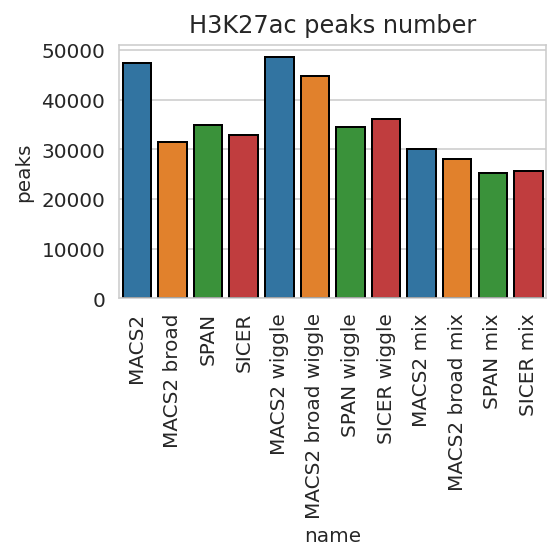

In [25]:
order = [f'{tool}{suffix}' for (suffix, tool) in product(['', ' wiggle', ' mix'], ['MACS2', 'MACS2 broad', 'SPAN', 'SICER'])]
palette = {f'{tool}{suffix}': TOOLS_PALETTE[tool] 
           for (suffix, tool) in product(['', ' wiggle', ' mix'], ['MACS2', 'MACS2 broad', 'SPAN', 'SICER'])}

plt.figure(figsize=(4, 4))
ax = plt.axes()
g_results = sns.barplot(data=df_fdr_peaks_mix_wiggle, x='name', y='peaks', ax=ax,
                        capsize=.2, errwidth=2, edgecolor="black",
                        palette=palette,
                        order=order)
ax.xaxis.set_tick_params(rotation=90)
ax.title.set_text('H3K27ac peaks number')
plt.tight_layout()
plt.savefig(f'{GSE26320_PATH_HG38}/pics/H3K27ac_wiggle_mix_peaks.pdf', bbox_inches='tight', dpi=300)
plt.show()

# Difference between broad and narrow peaks

In [26]:
! mkdir -p {WD}/union

perc_len_dfs = []
perc_peaks_df = pd.DataFrame(columns=['type', 'length', 'tool', 'peaks'], dtype=object)

for ty in tqdm(df_fdr_peaks_mix_wiggle['type'].unique()):
    tf = tempfile.mktemp()

    print(ty)
    t = df_fdr_peaks_mix_wiggle[(df_fdr_peaks_mix_wiggle['modification'] == 'H3K27ac') &
                     (df_fdr_peaks_mix_wiggle['type'] == ty)]
    if len(t) == 0:
        continue
    try:
        t_span = sorted_file(t[t['tool'] == 'SPAN']['file'].values[0])
        t_macs2 = sorted_file(t[t['tool'] == 'MACS2']['file'].values[0])
        t_macs2broad = sorted_file(t[t['tool'] == 'MACS2 broad']['file'].values[0])
        t_sicer = sorted_file(t[t['tool'] == 'SICER']['file'].values[0])
        # Prepare total overlap
        union_path = f'{WD}/union/H3K27ac_{ty}.bed'
        ! bedtools multiinter -i {t_span} {t_macs2} {t_macs2broad} {t_sicer} > {tf}
        ! bedtools merge -i {tf} > {union_path}
        t = pd.read_csv(union_path, sep='\t', header=None, usecols=[0, 1, 2])
        t[3] = t[2] - t[1]
        t.sort_values(by=[3, 0, 1, 2], inplace=True)
        # Take % peaks by lengths and compute ratios inside
        step = 20
        for percentage in [0, 20, 40, 60, 80]:
            percentage_name = f'{percentage}%-{percentage + step}%'
            t.iloc[int(len(t) * percentage / 100):int(len(t) * (percentage + step) / 100)][[0, 1, 2]].to_csv(
                tf, sep='\t', index=False, header=None
            )
            for tool, file in [('MACS2', t_macs2), ('MACS2 broad', t_macs2broad), ('SPAN', t_span), ('SICER', t_sicer)]:
                # Prepare tool percentage peaks
                ! bedtools intersect -wa -u -a {file} -b {sorted_file(tf)} > {file}-perc
                # print(tool)
                # ! wc -l {file}-perc
                peak_lengths = bedl(f'{file}-perc')
                tl = pd.DataFrame(dict(peak_lengths=peak_lengths))
                tl['name'] = tool
                tl['type'] = ty
                tl['length'] = percentage_name
                perc_peaks_df.loc[len(perc_peaks_df)] = (ty, percentage_name, tool, len(peak_lengths))
                perc_len_dfs.append(tl.sample(min(len(tl), 10_000)))

    except Exception as e:
        print(e)

display(perc_peaks_df.sample(3))
perc_len_df = pd.concat(perc_len_dfs).reset_index(drop=True)
del perc_len_dfs
display(perc_len_df.sample(3))

  0%|          | 0/3 [00:00<?, ?it/s]

mix
base
wiggle


,type,length,tool,peaks
42,wiggle,0%-20%,SPAN,6815
10,mix,40%-60%,SPAN,4643
28,base,40%-60%,MACS2,6927


,peak_lengths,name,type,length
240128,746,MACS2 broad,wiggle,0%-20%
58759,1280,MACS2 broad,mix,60%-80%
49879,487,MACS2,mix,60%-80%


base
wiggle
mix


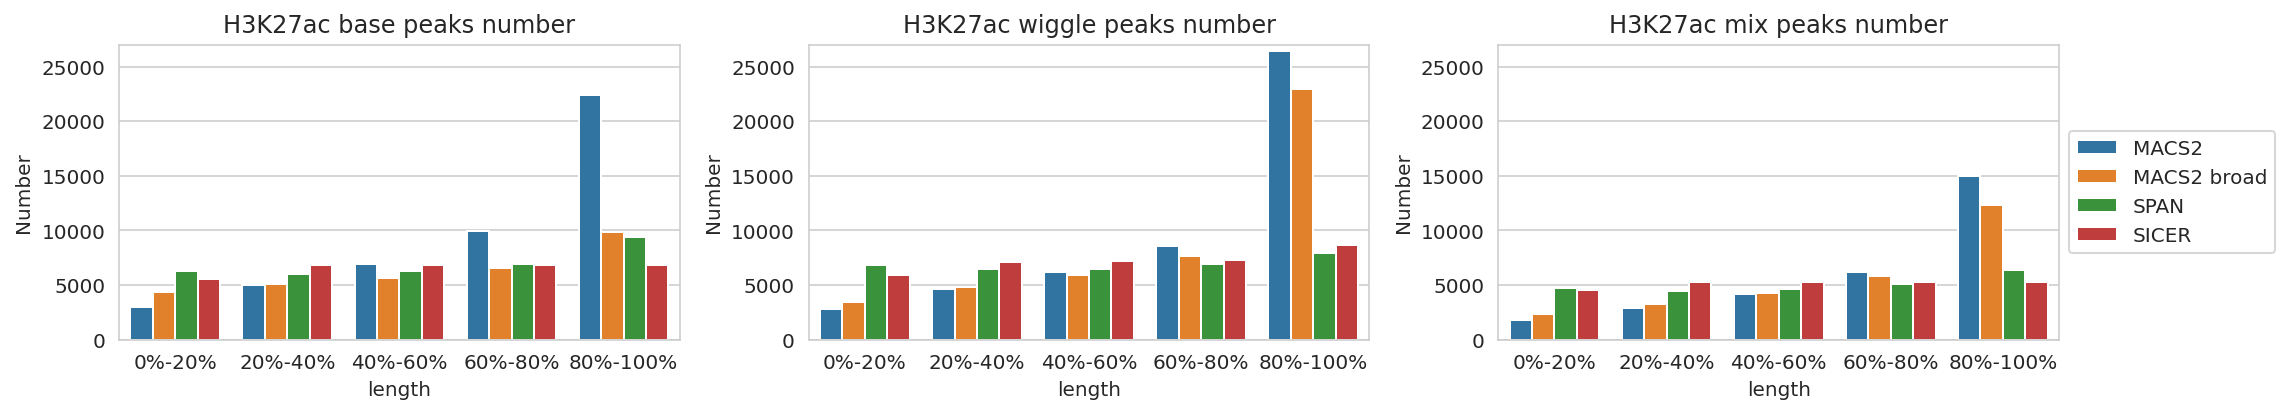

In [27]:
plt.figure(figsize=(16, 3))
axs = [plt.subplot(1, 3, i + 1) for i in range(3)]


for i, ty in enumerate(['base', 'wiggle', 'mix']):
    tf = tempfile.mktemp()

    print(ty)
    ax = axs[i]
    g_results = sns.barplot(data=perc_peaks_df[perc_peaks_df['type'] == ty],
                            y='peaks', x='length', ax=ax,
                            hue='tool',
                            hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                            palette=TOOLS_PALETTE,
                            )
    ax.title.set_text(f'H3K27ac {ty} peaks number')
    g_results.axes.set_ylabel('Number')
    ax.set_ylim(0, 27_000)
    if i != 2:
        ax.legend().set_visible(False)
    else:
        # Put a legend to the right of the current axis
        g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.savefig(f'{GSE26320_PATH_HG38}/pics/H3K27ac_wiggle_mix_percentiles.pdf', bbox_inches='tight', dpi=300)
plt.show()

base
wiggle
mix


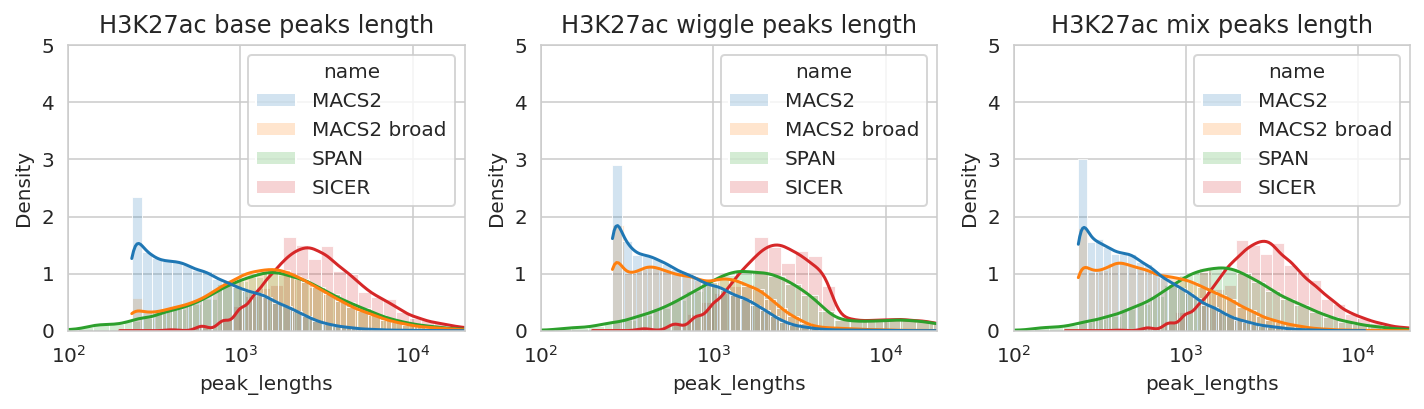

In [28]:
plt.figure(figsize=(10, 3))
axs = [plt.subplot(1, 3, i + 1) for i in range(3)]

for i, ty in enumerate(['base', 'wiggle', 'mix']):
    tf = tempfile.mktemp()
    print(ty)
    ax = axs[i]
    g_results = sns.histplot(data=perc_len_df[perc_len_df['type'] == ty], x='peak_lengths', hue='name', ax=ax,
                             stat='density', common_bins=False, common_norm=False,
                             bins=35, kde=True, log_scale=True, alpha=0.2,
                             palette=TOOLS_PALETTE,
                             hue_order=TOOLS)
    g_results.set(xscale='log')
    g_results.set_ylim(0, 5)
    g_results.set_xlim(1e2, 2e4)
    ax.title.set_text(f'H3K27ac {ty} peaks length')

plt.tight_layout()
plt.savefig(f'{GSE26320_PATH_HG38}/pics/H3K27ac_wiggle_mix_lengths.pdf', bbox_inches='tight', dpi=300)
plt.show()

# Estimate Coverage variance in mix / wiggle regions

In [142]:
from math import ceil
import pyBigWig

RD = os.path.expanduser('~/data/2023_Immune')
bed_encode = os.path.expanduser('~/data/2023_GSE26320/percentiles/80%-100%_H3K27ac_GM12878_rep1.bed')
bed_roadmap = f'{RD}/percentiles/80%-100%_H3K27ac_TCell.bed'
data = [
    ('wiggle', f'{WD}/bw/GSM646316_GM12878_H3K27ac_rep1_wiggle.bw', bed_encode),
    ('mix', f'{WD}/bw/GSM646316_GM12878_H3K27ac_rep1_mix.bw', bed_encode),
    ('ENCODE', f'{os.path.expanduser("~/data/2023_GSE26320/bw/GSM646316_GM12878_H3K27ac_rep1.bw")}', bed_encode),
    ('Roadmap', f'{RD}/bw/TCell_H3K27ac_hg38_ENCFF530DQB.bw', bed_roadmap)
]

variances = []
bin = 100
for name, bwf, percf in data:
    print(name, bwf, percf)
    t = pd.read_csv(percf, sep='\t', header=None)
    with pyBigWig.open(bwf) as bw:
        # Resort top scored peaks by density and start with the most dense ones
        total_coverage = sum(bw.stats(chr, exact=True, type='sum')[0] for chr in CHROM_SIZES.keys() if '_' not in chr) / 1e6
        print('Total coverage', total_coverage)
        for chr, start, end in tqdm(zip(t[0], t[1], t[2])):
            if chr in CHROM_SIZES:
                # Normalize by total coverage
                stats = [c / total_coverage for c in bw.stats(chr, start, end, nBins=int(ceil((end - start) / bin)), exact=True)]
                variances.append((name, f'{chr}:{start}-{end}', np.var(stats))) 
            
df_vars = pd.DataFrame(variances, columns=['name', 'position', 'variance'])
del variances
df_vars.sample(5)

wiggle /home/jetbrains/data/2023_GSE26320_wiggle_80_100/bw/GSM646316_GM12878_H3K27ac_rep1_wiggle.bw /home/jetbrains/data/2023_GSE26320/percentiles/80%-100%_H3K27ac_GM12878_rep1.bed
Total coverage 97.35159199852752


0it [00:00, ?it/s]

mix /home/jetbrains/data/2023_GSE26320_wiggle_80_100/bw/GSM646316_GM12878_H3K27ac_rep1_mix.bw /home/jetbrains/data/2023_GSE26320/percentiles/80%-100%_H3K27ac_GM12878_rep1.bed
Total coverage 98.46774641990662


0it [00:00, ?it/s]

ENCODE /home/jetbrains/data/2023_GSE26320/bw/GSM646316_GM12878_H3K27ac_rep1.bw /home/jetbrains/data/2023_GSE26320/percentiles/80%-100%_H3K27ac_GM12878_rep1.bed
Total coverage 95.99449994272328


0it [00:00, ?it/s]

Roadmap /home/jetbrains/data/2023_Immune/bw/TCell_H3K27ac_hg38_ENCFF530DQB.bw /home/jetbrains/data/2023_Immune/percentiles/80%-100%_H3K27ac_TCell.bed
Total coverage 84.9097751298113


0it [00:00, ?it/s]

,name,position,variance
1293,wiggle,chr16:8795800-8801399,0.000009
3584,wiggle,chr2:55045394-55052656,0.000005
14283,ENCODE,chr22:25447200-25452399,0.000005
2593,wiggle,chr5:14592400-14598799,0.000003
7464,mix,chr22:21856800-21861999,0.000001


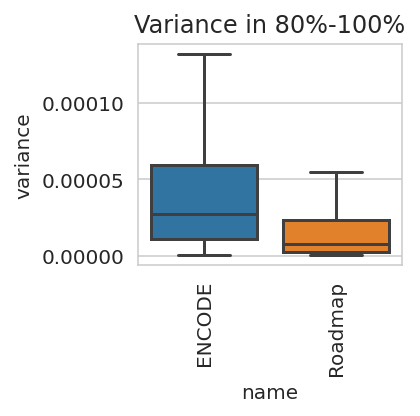

In [146]:
plt.figure(figsize=(3, 3))
ax = plt.axes()
g_results = sns.boxplot(data=df_vars[(df_vars['name'] == 'ENCODE') | (df_vars['name'] == 'Roadmap')], x='name', y='variance', showfliers=False)
ax.xaxis.set_tick_params(rotation=90)
ax.title.set_text('Variance in 80%-100%')
plt.tight_layout()
plt.show()

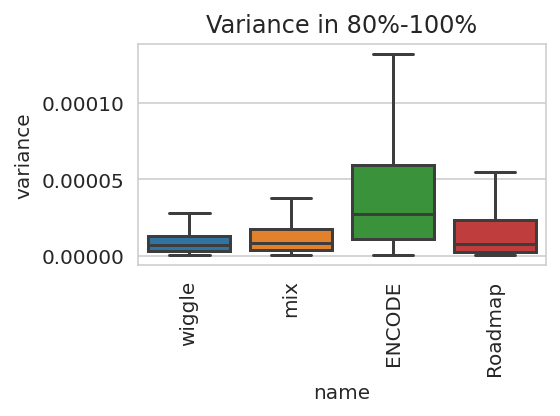

In [147]:
plt.figure(figsize=(4, 3))
ax = plt.axes()
g_results = sns.boxplot(data=df_vars, x='name', y='variance', showfliers=False)
ax.xaxis.set_tick_params(rotation=90)
ax.title.set_text('Variance in 80%-100%')
plt.tight_layout()
plt.show()

# Compare Jaccard between MACS2 broad and SPAN

## GM12878

In [84]:
reps = {
    'MACS2 broad': [f'{GSE26320_PATH_HG38}/macs2/GSM646316_GM12878_H3K27ac_rep1_broad0.1_peaks.broadPeak',
                    f'{GSE26320_PATH_HG38}/macs2/GSM646317_GM12878_H3K27ac_rep2_broad0.1_peaks.broadPeak'],
    'SPAN': [f'{GSE26320_PATH_HG38}/span/GSM646316_GM12878_H3K27ac_rep1_100_0.05_3.peak',
             f'{GSE26320_PATH_HG38}/span/GSM646317_GM12878_H3K27ac_rep2_100_0.05_3.peak']
}
print('SPAN r1', lines(reps['SPAN'][0]), bedl(reps['SPAN'][0]).sum())
print('SPAN r2', lines(reps['SPAN'][1]), bedl(reps['SPAN'][1]).sum())

SPAN r1 34842 78383419
SPAN r2 31050 70478499


In [85]:
import tempfile

perc_reps_overlap = pd.DataFrame(
    columns=['tool', 'length_percentage',
             'peaks1', 'peaks1_len', 'peaks2', 'peaks2_len',
             'peaks1_overlap', 'peaks1_overlap_len',
             'peaks2_overlap', 'peaks2_overlap_len'], dtype=object)

dfso = []
dfsl = []
for tool, (rep1, rep2) in reps.items():
    tf = tempfile.mktemp()
    # This prints only overlapping A and B features, skipping non-overlapping
    !bedtools intersect -a {sorted_file(rep1)} -b {sorted_file(rep2)} -wo > {tf}
    t = pd.read_csv(tf, sep='\t', header=None)
    tl = pd.DataFrame(dict(diff=pd.concat([t[10] - t[1], t[11] - t[2]]).reset_index(drop=True), 
                           overlap=pd.concat([t[18], t[18]]).reset_index(drop=True)))
    tl['name'] = tool
    dfsl.append(tl)
    
tl = pd.concat(dfsl).reset_index(drop=True)
display(tl.sample(3))

,diff,overlap,name
6981,73,732,MACS2 broad
424,-618,440,MACS2 broad
72758,170,5697,SPAN


In [86]:
tl['abs_diff'] = np.fabs(tl['diff']) + 1
tl = tl[(tl['overlap'] < 10_000) & (tl['abs_diff'] < 10_000)]

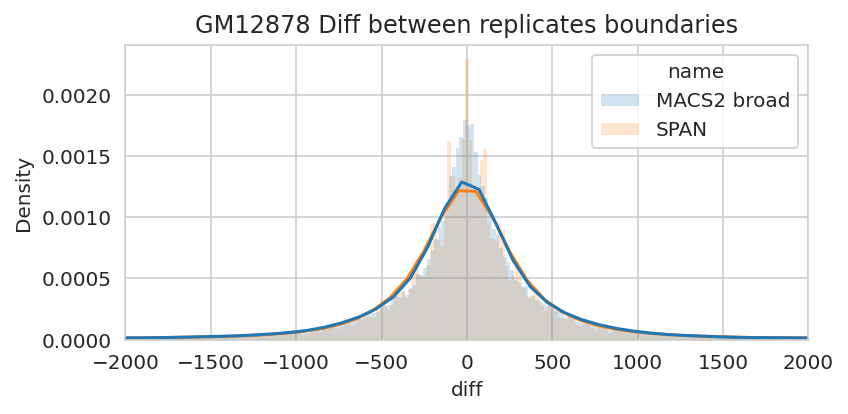

In [87]:
plt.figure(figsize=(6, 3))
g_results = sns.histplot(data=tl, x='diff', hue='name',
                         stat='density', common_bins=False, common_norm=False,
                         kde=True, alpha=0.2)
g_results.set_xlim(-2_000, 2_000)
g_results.axes.title.set_text(f'GM12878 Diff between replicates boundaries')

plt.tight_layout()
plt.show()

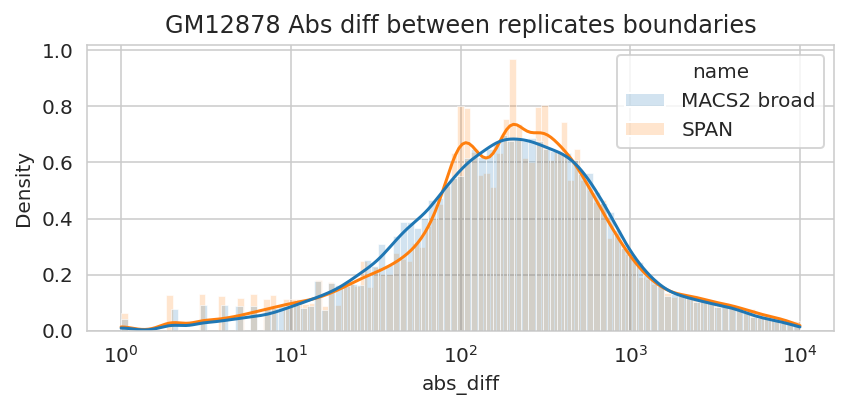

In [88]:
plt.figure(figsize=(6, 3))
g_results = sns.histplot(data=tl, x='abs_diff', hue='name',
                         stat='density', common_bins=False, common_norm=False,
                         kde=True, log_scale=True, alpha=0.2)
g_results.set(xscale='log')
g_results.axes.title.set_text(f'GM12878 Abs diff between replicates boundaries')

plt.tight_layout()
plt.show()

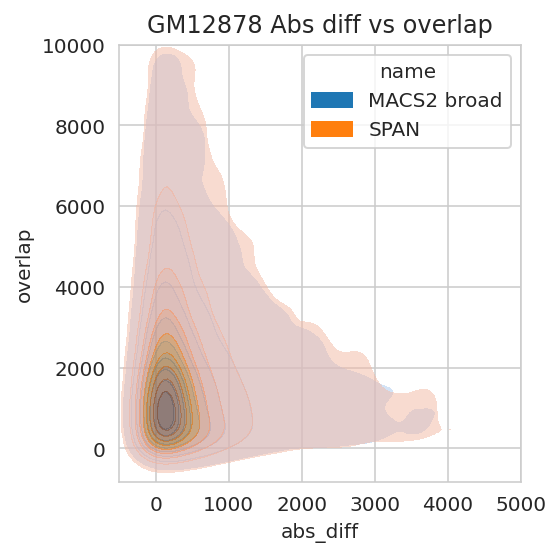

In [89]:
plt.figure(figsize=(4, 4))
g_results = sns.kdeplot(data=tl, x='abs_diff', y='overlap', hue='name', fill=True, alpha=0.5)
g_results.set_xlim(xmax=5_000)
g_results.set_ylim(ymax=10_000)
g_results.axes.title.set_text(f'GM12878 Abs diff vs overlap')
plt.tight_layout()
plt.show()

## HSMM

In [91]:
reps = {
    'MACS2 broad': [f'{GSE26320_PATH_HG38}/macs2/GSM646394_HSMM_H3K27ac_rep1_broad0.1_peaks.broadPeak',
                    f'{GSE26320_PATH_HG38}/macs2/GSM646395_HSMM_H3K27ac_rep2_broad0.1_peaks.broadPeak'],
    'SPAN': [f'{GSE26320_PATH_HG38}/span/GSM646394_HSMM_H3K27ac_rep1_100_0.05_3.peak',
             f'{GSE26320_PATH_HG38}/span/GSM646395_HSMM_H3K27ac_rep2_100_0.05_3.peak']
}
print('SPAN r1', lines(reps['SPAN'][0]), bedl(reps['SPAN'][0]).sum())
print('SPAN r2', lines(reps['SPAN'][1]), bedl(reps['SPAN'][1]).sum())

HSMM cell line
SPAN r1 38858 60035458
SPAN r2 49653 75247739


In [92]:
import tempfile

perc_reps_overlap = pd.DataFrame(
    columns=['tool', 'length_percentage',
             'peaks1', 'peaks1_len', 'peaks2', 'peaks2_len',
             'peaks1_overlap', 'peaks1_overlap_len',
             'peaks2_overlap', 'peaks2_overlap_len'], dtype=object)

dfso = []
dfsl = []
for tool, (rep1, rep2) in reps.items():
    tf = tempfile.mktemp()
    # This prints only overlapping A and B features, skipping non-overlapping
    !bedtools intersect -a {sorted_file(rep1)} -b {sorted_file(rep2)} -wo > {tf}
    t = pd.read_csv(tf, sep='\t', header=None)
    tl = pd.DataFrame(dict(diff=pd.concat([t[10] - t[1], t[11] - t[2]]).reset_index(drop=True),
                           overlap=pd.concat([t[18], t[18]]).reset_index(drop=True)))
    tl['name'] = tool
    dfsl.append(tl)

tl = pd.concat(dfsl).reset_index(drop=True)
display(tl.sample(3))

,diff,overlap,name
55709,-279,1348,MACS2 broad
67557,-430,934,MACS2 broad
90163,79,1154,SPAN


In [93]:
tl['abs_diff'] = np.fabs(tl['diff']) + 1
tl = tl[(tl['overlap'] < 10_000) & (tl['abs_diff'] < 10_000)]

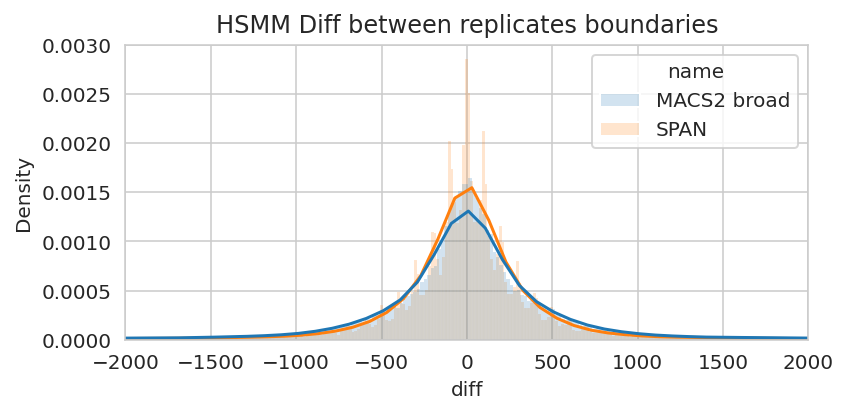

In [94]:
plt.figure(figsize=(6, 3))
g_results = sns.histplot(data=tl, x='diff', hue='name',
                         stat='density', common_bins=False, common_norm=False,
                         kde=True, alpha=0.2)
g_results.set_xlim(-2_000, 2_000)
g_results.axes.title.set_text(f'HSMM Diff between replicates boundaries')

plt.tight_layout()
plt.show()

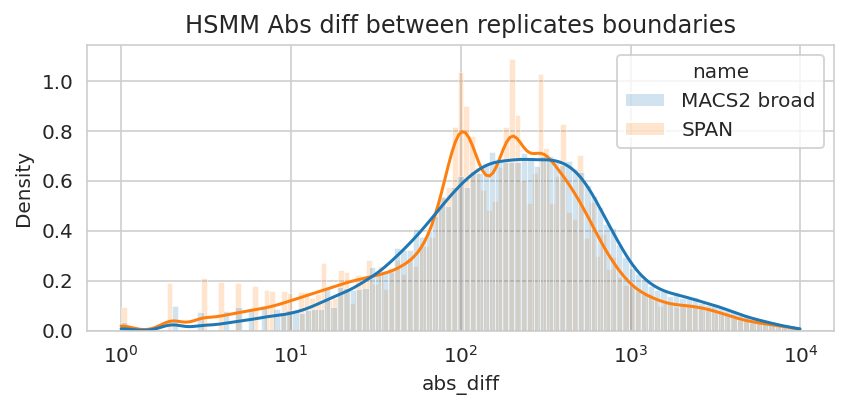

In [95]:
plt.figure(figsize=(6, 3))
g_results = sns.histplot(data=tl, x='abs_diff', hue='name',
                         stat='density', common_bins=False, common_norm=False,
                         kde=True, log_scale=True, alpha=0.2)
g_results.set(xscale='log')
g_results.axes.title.set_text(f'HSMM Abs diff between replicates boundaries')

plt.tight_layout()
plt.show()

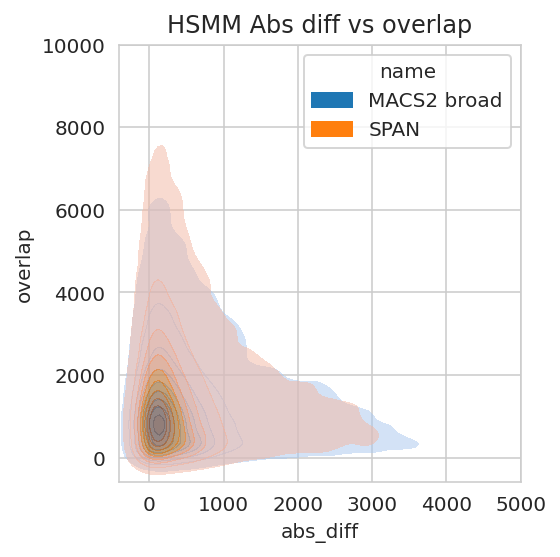

In [96]:
plt.figure(figsize=(4, 4))
g_results = sns.kdeplot(data=tl, x='abs_diff', y='overlap', hue='name', fill=True, alpha=0.5)
g_results.set_xlim(xmax=5_000)
g_results.set_ylim(ymax=10_000)
g_results.axes.title.set_text(f'HSMM Abs diff vs overlap')
plt.tight_layout()
plt.show()

## HMEC

In [99]:
reps = {
    'MACS2 broad': [f'{GSE26320_PATH_HG38}/macs2/GSM646374_HMEC_H3K27ac_rep1_broad0.1_peaks.broadPeak',
                    f'{GSE26320_PATH_HG38}/macs2/GSM646375_HMEC_H3K27ac_rep2_broad0.1_peaks.broadPeak'],
    'SPAN': [f'{GSE26320_PATH_HG38}/span/GSM646374_HMEC_H3K27ac_rep1_100_0.05_3.peak',
             f'{GSE26320_PATH_HG38}/span/GSM646375_HMEC_H3K27ac_rep2_100_0.05_3.peak']
}
print('SPAN r1', lines(reps['SPAN'][0]), bedl(reps['SPAN'][0]).sum())
print('SPAN r2', lines(reps['SPAN'][1]), bedl(reps['SPAN'][1]).sum())

SPAN r1 47858 82240423
SPAN r2 30534 51621487


In [100]:
import tempfile

perc_reps_overlap = pd.DataFrame(
    columns=['tool', 'length_percentage',
             'peaks1', 'peaks1_len', 'peaks2', 'peaks2_len',
             'peaks1_overlap', 'peaks1_overlap_len',
             'peaks2_overlap', 'peaks2_overlap_len'], dtype=object)

dfso = []
dfsl = []
for tool, (rep1, rep2) in reps.items():
    tf = tempfile.mktemp()
    # This prints only overlapping A and B features, skipping non-overlapping
    !bedtools intersect -a {sorted_file(rep1)} -b {sorted_file(rep2)} -wo > {tf}
    t = pd.read_csv(tf, sep='\t', header=None)
    tl = pd.DataFrame(dict(diff=pd.concat([t[10] - t[1], t[11] - t[2]]).reset_index(drop=True),
                           overlap=pd.concat([t[18], t[18]]).reset_index(drop=True)))
    tl['name'] = tool
    dfsl.append(tl)

tl = pd.concat(dfsl).reset_index(drop=True)
display(tl.sample(3))

,diff,overlap,name
52787,945,462,MACS2 broad
17830,-905,1307,MACS2 broad
50783,378,630,MACS2 broad


In [101]:
tl['abs_diff'] = np.fabs(tl['diff']) + 1
tl = tl[(tl['overlap'] < 10_000) & (tl['abs_diff'] < 10_000)]

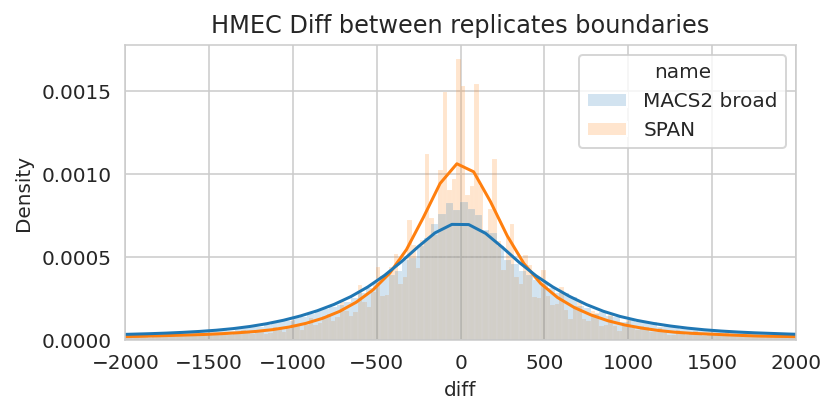

In [103]:
plt.figure(figsize=(6, 3))
g_results = sns.histplot(data=tl, x='diff', hue='name',
                         stat='density', common_bins=False, common_norm=False,
                         kde=True, alpha=0.2)
g_results.set_xlim(-2_000, 2_000)
g_results.axes.title.set_text(f'HMEC Diff between replicates boundaries')

plt.tight_layout()
plt.show()

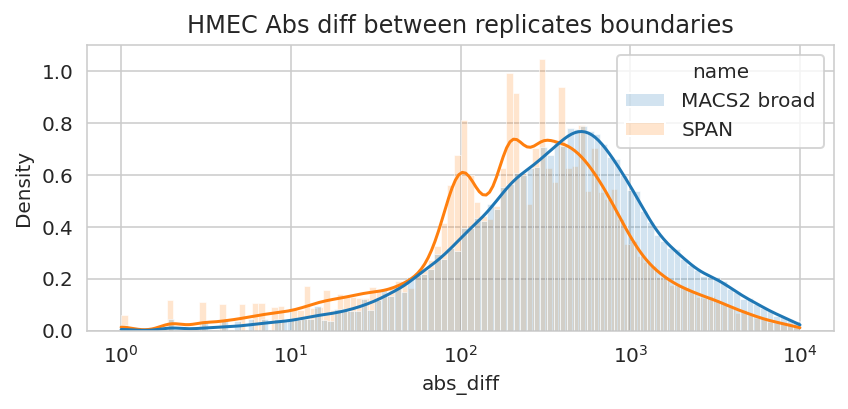

In [104]:
plt.figure(figsize=(6, 3))
g_results = sns.histplot(data=tl, x='abs_diff', hue='name',
                         stat='density', common_bins=False, common_norm=False,
                         kde=True, log_scale=True, alpha=0.2)
g_results.set(xscale='log')
g_results.axes.title.set_text(f'HMEC Abs diff between replicates boundaries')

plt.tight_layout()
plt.show()

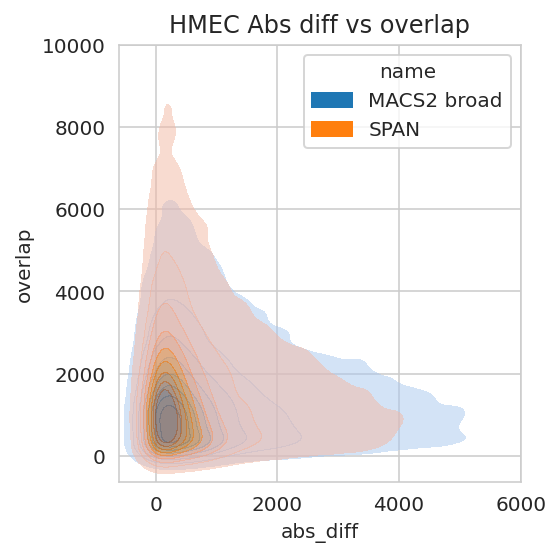

In [106]:
plt.figure(figsize=(4, 4))
g_results = sns.kdeplot(data=tl, x='abs_diff', y='overlap', hue='name', fill=True, alpha=0.5)
g_results.set_xlim(xmax=6_000)
g_results.set_ylim(ymax=10_000)
g_results.axes.title.set_text(f'HMEC Abs diff vs overlap')
plt.tight_layout()
plt.show()

# END